# Paleontology Machine Learning Project


---

## Explanation 

This project is based on a data base found on https://data.world/bryon/paleobiodb. It is called Paleobilogy Database and is a public database of paleontological data.
This database contains the list of fossiles found on earth with their found locations,descriptions, genuses etc.. 


**What are the main objectives of this project?** 
- study the data attributes to estimate which factors are most important when determining the identity of a given fossil sample.
- test multiple machine learning algorithm to predict the genus of a fossile according to its features.
- compare efficiency/accuracy of those algorithms to understand which algorithm is best fitted for this type of machine learning problem.

---


## Glossary <a id='glossary'></a>
 0) [Processing data](#processing_data)
 1) [KNN in 2D](#knn2D)
 2) [KNN in 3D](#knn3d)
 3) [Logistic regression](#logistic_regression)
 4) [Decision tree](#decision_tree)
 5) [PCA for higher dimensions](#pca)

(you can click on the links to jump directly to each subpart)

---

#### Import libraries

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import graphviz

from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingRegressor

#Import stuff for k-nearest neighbor 
import sklearn.neighbors
import sklearn.linear_model
from sklearn.utils import shuffle
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap

#iwidgets


#import google.colab
#from google.colab import files
#uploaded = files.upload()

ModuleNotFoundError: No module named 'graphviz'

---

## 0) Processing data <a id='processing_data'> </a>

In [2]:
data = pd.read_csv('thegigafile.csv')

In [3]:
#Vizualising data 
data

,max_ma,min_ma,genus,lng,lat,paleolng,paleolat,lithology1,composition
0,353.8,345.3,Australosutura,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
1,353.8,345.3,Carbonocoryphe,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
2,353.8,345.3,Thigriffides,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
3,353.8,345.3,Pudoproetus,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
4,353.8,345.3,Pudoproetus,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
...,...,...,...,...,...,...,...,...,...
743654,99.6,93.5,Lepicerus,96.720001,26.360001,105.50,8.29,amber,chitin
743655,468.1,460.9,Eremotoechia,-86.784721,33.311111,-114.63,-8.13,"""limestone""",low Mg calcite
743656,467.3,458.4,Eremotoechia,-84.129166,35.741669,-112.38,-10.30,"""limestone""",low Mg calcite
743657,467.3,458.4,Eremotoechia,-84.125000,35.750000,-112.37,-10.29,"""limestone""",low Mg calcite


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743659 entries, 0 to 743658
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   max_ma       743659 non-null  float64
 1   min_ma       743659 non-null  float64
 2   genus        743659 non-null  object 
 3   lng          743659 non-null  float64
 4   lat          743659 non-null  float64
 5   paleolng     743659 non-null  float64
 6   paleolat     743659 non-null  float64
 7   lithology1   743659 non-null  object 
 8   composition  743659 non-null  object 
dtypes: float64(6), object(3)
memory usage: 51.1+ MB


In [5]:
data_only_one_genus =  data[data['genus'].isin(['Modiolus'])]
data_only_one_genus 

,max_ma,min_ma,genus,lng,lat,paleolng,paleolat,lithology1,composition
513,305.90,303.400,Modiolus,-95.847504,36.675556,-28.72,-3.52,"""shale""","aragonite, low Mg calcite"
5420,346.70,330.900,Modiolus,-3.850000,56.616669,-9.62,-27.47,lime mudstone,"aragonite, low Mg calcite"
11082,163.50,145.000,Modiolus,-21.969999,70.480003,14.74,46.43,sandstone,"aragonite, low Mg calcite"
11102,152.10,145.000,Modiolus,-21.969999,70.480003,13.83,46.14,sandstone,"aragonite, low Mg calcite"
11153,152.10,145.000,Modiolus,-21.969999,70.480003,13.83,46.14,sandstone,"aragonite, low Mg calcite"
...,...,...,...,...,...,...,...,...,...
739914,15.97,11.608,Modiolus,132.750000,35.349998,130.45,34.90,not reported,"aragonite, low Mg calcite"
741465,72.10,66.000,Modiolus,-121.190002,37.459999,-85.07,50.28,"""siliciclastic""","aragonite, low Mg calcite"
741523,100.50,66.000,Modiolus,-121.176003,37.369999,-81.59,46.45,"""siliciclastic""","aragonite, low Mg calcite"
742199,72.10,66.000,Modiolus,-121.121002,37.224998,-85.08,50.04,sandstone,"aragonite, low Mg calcite"


looking at a single genus one can see that the composition is the same. 

---
## 1) K-nearest neighbor (Space/Genus) <a id='knn2D'></a>


The first model we will implement will be a kNN model in 2 dimensions: longitude and lattitude. Then we will try using paleolongitude and paleolattitude to compare.

#### [Jump back to glossary](#glossary)

### a) Data sampling

In [6]:
#Test here on only three data frame
new_table = data[['lng', 'lat', 'genus']].copy()

In [7]:
new_table

,lng,lat,genus
0,-98.099998,31.000000,Australosutura
1,-98.099998,31.000000,Carbonocoryphe
2,-98.099998,31.000000,Thigriffides
3,-98.099998,31.000000,Pudoproetus
4,-98.099998,31.000000,Pudoproetus
...,...,...,...
743654,96.720001,26.360001,Lepicerus
743655,-86.784721,33.311111,Eremotoechia
743656,-84.129166,35.741669,Eremotoechia
743657,-84.125000,35.750000,Eremotoechia


### b) Using k-nearest neighbor with 3 genuses 

#### i) Look at the most occurences of genuses 

In [8]:
genus_counts = new_table['genus'].value_counts().reset_index()
genus_counts.columns = ['genus', 'count']
genus_counts = genus_counts.sort_values(by='count', ascending=False)

# Print the ranking
#print("Ranking of genera with the most occurrences:")
#for index, row in genus_counts.iterrows():
#    print(f"{index+1}. {row['genus']}: {row['count']} occurrences")

#### ii) create kNN classification on a small data subset 

In [9]:
filtered_table = new_table[new_table['genus'].isin(['Eremotoechia', 'Pudoproetus', 'Carbonocoryphe'])]
filtered_table = filtered_table.sample(frac=1).reset_index(drop=True)
len(filtered_table)

38

In [10]:
#plotting function 
def plot_scatter(color_map, data_set, x_column, y_column, group_column):
    plt.figure(figsize=(10, 6))
    for group, group_data in data_set.groupby(group_column):
        plt.scatter(group_data[x_column], group_data[y_column], label=group, color=color_map.get(group, 'black'))
    
    plt.xlabel(x_column.capitalize())
    plt.ylabel(y_column.capitalize())
    plt.title(f'Scatter Plot of {x_column.capitalize()} vs {y_column.capitalize()}')
    plt.legend()
    plt.show()

In [11]:
#knn -classification function 
def knn_classification(data, features, target, test_size=0.2, n_neighbors=5):
    # Split the data into features (X) and target (y)
    X = data[features]
    y = data[target]
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Initialize the KNN classifier
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the model
    model.fit(x_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(x_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy


##### Decision boundary for k = 3 

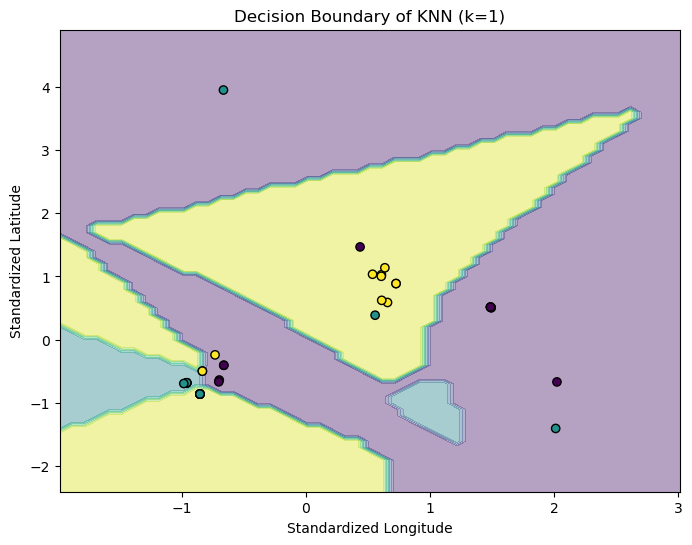

In [12]:
X = filtered_table[['lng', 'lat']]
y = filtered_table['genus']

y = filtered_table['genus'].replace({'Carbonocoryphe': 2,'Pudoproetus': 1, 'Eremotoechia': 0})
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and train the k-nearest neighbors classifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_scaled, y)


# Plot the decision boundary
h = 0.1  # step size in the mesh
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Standardized Longitude')
plt.ylabel('Standardized Latitude')
plt.title('Decision Boundary of KNN (k=1)')
plt.show()

In [13]:
accuracy = knn_classification(filtered_table, ['lng', 'lat'], 'genus', test_size=0.2, n_neighbors=2)


print("Accuracy:", accuracy)

Accuracy: 0.625


#### iii) kNN classification on bigger data

In [14]:
filtered_table2 = new_table[new_table['genus'].isin(['Ostrea', 'Composita', 'Chlamys'])]

In [15]:
filtered_table2= filtered_table2.sample(frac=1).reset_index(drop=True)# --> shuffle the rows 
filtered_table2

,lng,lat,genus
0,-99.000000,29.055279,Ostrea
1,-87.629166,34.587502,Composita
2,-114.833336,40.416668,Composita
3,-80.341667,40.891666,Composita
4,-93.981110,38.283890,Composita
...,...,...,...
5076,62.250000,25.250000,Chlamys
5077,-76.304726,-13.794167,Ostrea
5078,-96.993889,33.046112,Ostrea
5079,-97.059998,32.859444,Ostrea


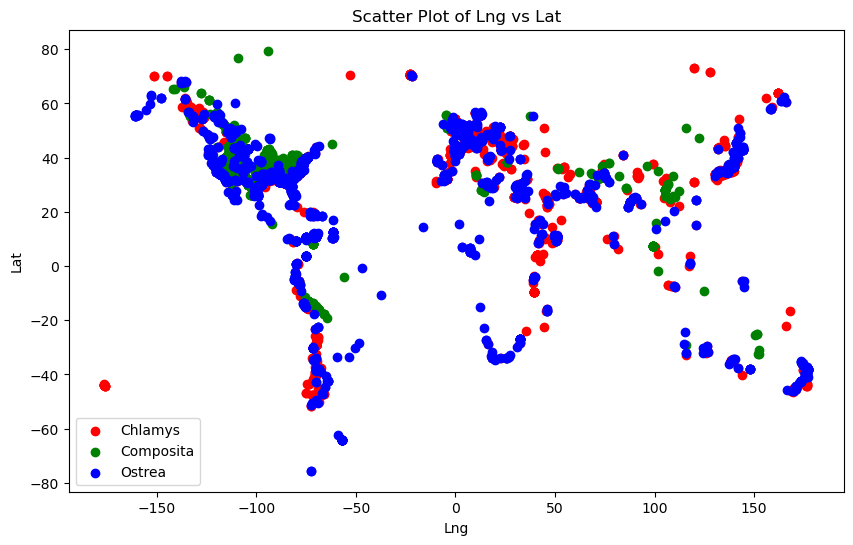

In [16]:
color_map = {
    'Ostrea': 'blue',
    'Composita': 'green',
    'Chlamys': 'red'
}

# Create a scatter plot
plot_scatter(color_map, filtered_table2, 'lng', 'lat', 'genus')


#### iv) Drawing the decision boundary for k =3 

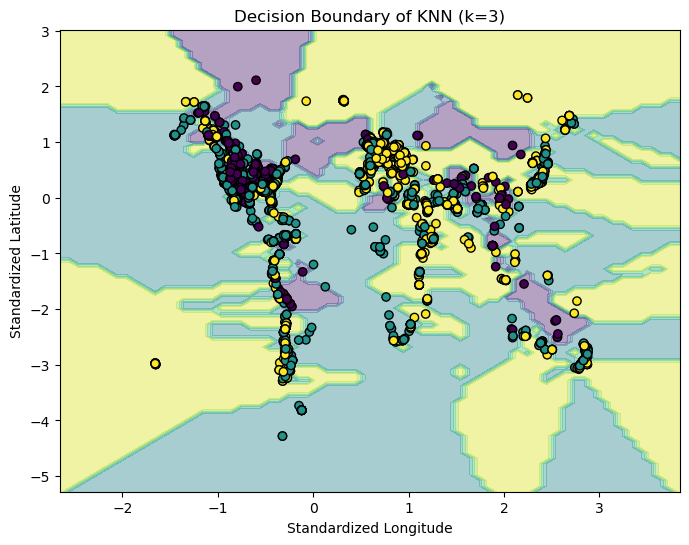

In [17]:
X = filtered_table2[['lng', 'lat']]
y = filtered_table2['genus']

y = filtered_table2['genus'].replace({'Chlamys': 2,'Ostrea': 1, 'Composita': 0})
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and train the k-nearest neighbors classifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_scaled, y)


# Plot the decision boundary
h = 0.1  # step size in the mesh
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Standardized Longitude')
plt.ylabel('Standardized Latitude')
plt.title('Decision Boundary of KNN (k=3)')
plt.show()

In [18]:
accuracy = knn_classification(filtered_table2, ['lng', 'lat'], 'genus', test_size=0.2, n_neighbors=2)


print("Accuracy:", accuracy)

Accuracy: 0.8289085545722714


Very good accuracy at around 80% 

However, there are **major problems**  to such approach : 

- we taking the longitude and latitude of species that may have lived millions years away but maybe at the same place --> time has to be taken into account 

- longitude and latitude in 2D is prone to many errors (example : fossile in Alaska and in Kamchatka are close but in terms of longitude and latitude there are in opposite places)

### c) Expanding kNN to 10 genera 

In [19]:
filtered_table3 = new_table[new_table['genus'].isin(['Ostrea', 'Composita', 'Chlamys','Inoceramus','Derbyia',"Panderodus","Nuculana","Polygnathus","Cleiothyridina","Modiolus"])]
filtered_table3 = filtered_table3.sample(frac=1).reset_index(drop=True) #randomizing 

In [20]:
accuracy3 = knn_classification(filtered_table3, ['lng', 'lat'], 'genus', test_size=0.2, n_neighbors=7)
print("Accuracy:", accuracy3)

Accuracy: 0.6135213304410702


Testing with different values of n_neighbors, we find that the accuracy for testing with 10 genera is caped at 60%

### d) Paleolongitude kNN 

#### a) knn with 3 genera 

In [21]:
paleotable = data[['paleolng', 'paleolat', 'genus']].copy()

In [22]:
filtered_paleotable = paleotable[paleotable['genus'].isin(['Ostrea', 'Composita', 'Chlamys'])]
filtered_paleotable = filtered_paleotable.sample(frac=1).reset_index(drop=True)

In [23]:
accuracy = knn_classification(filtered_paleotable, ['paleolng', 'paleolat'], 'genus', test_size=0.2, n_neighbors=3)
accuracy

0.8466076696165191

#### b) knn with 10 genera 

In [24]:
filtered_paleotable2 = paleotable[paleotable['genus'].isin(['Ostrea', 'Composita', 'Chlamys','Inoceramus','Derbyia',"Panderodus","Nuculana","Polygnathus","Cleiothyridina","Modiolus"])]
filtered_paleotable2 = filtered_paleotable2.sample(frac=1).reset_index(drop=True)
accuracy4 = knn_classification(filtered_paleotable2, ['paleolng', 'paleolat'], 'genus', test_size=0.2, n_neighbors=9)
accuracy4

0.6048445408532176

 Once again even when using paleocoordinate when extending genera to more than 3, the accuracy gets quickly caped at 60. Hence another solution has to be provided. The solution might be to do kNN with a condition on it such as composition ? 

### e) Create new KNN more adapted to our dataset with 10 genuses 

The composition of fossiles from the same genus are very similar. Hence, we can take the assumption if two fossiles don't have the same composition, they will probably not be of the same genus. Hence we can create a new KNN classifier that takes this into account. It will search the location of the fossile and the fossiles nearby but will also look at the composition of the fossile before making the prediction.

#### KNN with condition on composition 

In [25]:
data3d=data.copy
data3d=data[['lng', 'lat', 'genus','composition']].copy()
data3d = data3d[data3d['genus'].isin(['Ostrea', 'Composita', 'Chlamys','Inoceramus','Derbyia',"Panderodus","Nuculana","Polygnathus","Cleiothyridina","Modiolus"])]
data3d = data3d.sample(frac=1).reset_index(drop=True) # randomize the rows so that there is no bias in the order of the rows
data3d

,lng,lat,genus,composition
0,12.866667,46.599998,Panderodus,hydroxyapatite
1,-86.483330,31.299999,Chlamys,"low Mg calcite, aragonite"
2,148.966660,-32.583332,Panderodus,hydroxyapatite
3,-78.023003,34.827999,Chlamys,"low Mg calcite, aragonite"
4,43.799999,15.683333,Ostrea,low Mg calcite
...,...,...,...,...
13822,71.714996,32.750000,Derbyia,low Mg calcite
13823,-62.333332,49.400002,Panderodus,hydroxyapatite
13824,-118.058334,53.083332,Cleiothyridina,low Mg calcite
13825,-103.245003,30.323999,Derbyia,low Mg calcite


In [26]:
import numpy as np

class KNNClassifier2:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X_train, y_train, compositions):
        self.X_train = X_train
        self.y_train = y_train
        self.compositions = compositions

    def predict(self, X_test, test_compositions):
        y_pred = []
        for sample, comp in zip(X_test, test_compositions):
            # Filter training samples by composition
            #print(self.compositions)
            mask = (self.compositions == comp)
            X_train_filtered = self.X_train[mask]
            y_train_filtered = self.y_train[mask]
            
            if len(X_train_filtered) == 0:
                y_pred.append(None)  # or handle the case where no training sample matches the composition
                continue

            # Compute distances in a vectorized way
            distances = np.sqrt(np.sum((X_train_filtered - sample) ** 2, axis=1))
            
            # Get indices of the k-nearest neighbors
            nearest_neighbors_idx = np.argsort(distances)[:self.n_neighbors]
            
            # Get the classes of the k-nearest neighbors
            nearest_neighbors = y_train_filtered[nearest_neighbors_idx]
            
            # Determine the most common class
            unique_classes, counts = np.unique(nearest_neighbors, return_counts=True)
            predicted_class = unique_classes[np.argmax(counts)]
            
            y_pred.append(predicted_class)
        
        return np.array(y_pred)

In [27]:
def knn_classification2(data, features, target, test_size=0.2, n_neighbors=5):
    # Split the data into features (X) and target (y)
    X = data[['lng', 'lat']].values
    y = data['genus'].values
    compositions = data['composition'].values

# Splitting data into train and test sets
    X_train, X_test, y_train, y_test, comp_train, comp_test = train_test_split(X, y, compositions, test_size=0.2, random_state=42)

    #print(X_train)
    #print(comp_train)
    
# Initializing and training the classifier
    knn = KNNClassifier2(n_neighbors=6)
    knn.fit(X_train, y_train, comp_train)

# Making predictions
    y_pred = knn.predict(X_test, comp_test)

# Evaluating the classifier
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    #print(f"Accuracy: {accuracy}")
    
    return accuracy


In [28]:
accuracy = knn_classification2(data3d,['lng', 'lat'], 'genus', test_size=0.2, n_neighbors=2)

print(accuracy)

0.812002892263196


80 % accuracy with putting a condition on the composition. This shows how the composition is a reliable feature to predict the genus. Trying on other features such as "lithology1" as a condition we get a decrease in the result --> 57% accuracy.  

Let us know look what we could do in the KNN with 3 features 

---
## 2) k nearest neighbor 3D (Space/ Time/ genuses) <a id='knn3d'></a>

#### [Jump back to glossary](#glossary)

### a) Preprocessing

In this section, we will work on 3D KNN to predict the 10 most common genuses. The first step will be to determine a metric and find a way to renormalize the distances so that KNN doesn't arbitrarily perceive some variables as more important than others.

In [78]:
#defining a new metric for 3D knn using haversine distance and difference in time
from sklearn.metrics.pairwise import haversine_distances
def timespace_metric(X: np.array ,Y: np.array):
    place1=X[:2]
    place2=Y[:2]
    space= haversine_distances([place1],[place2])/np.pi
    time=np.abs(X[-1]-Y[-1])/587.99415
    return (space+time)[0][0]

In [79]:
# checking for the max time difference to renormalize
matrix=data.values
mat=(matrix[:, 0]+matrix[:, 1])/2
M=max(mat)
m=min(mat)
M-m

587.99415

In [80]:
#looks good
timespace_metric(np.array([0,0,0]),np.array([np.pi,0,0]))

1.0

Now that we have a working metric, we will create our data from the large dataset. We decided to only choose 10 genuses to experiment with this, since we were not sure this would generalize well to a large number of genuses. We added a time variable compared to the previous model, we decided to simply average the minimum and the maximum dating of the fossil since this would serve as a good simple data point. We then shuffle the rows to not have any arbitrary bias when choosing the test data set.

In [81]:
#creating the right subdataframe
data3d=data.copy
data3d=data[['lng', 'lat', 'genus']].copy()
data3d['time']=(data['max_ma']+data['min_ma'])/2
data3d = data3d[data3d['genus'].isin(['Ostrea', 'Composita', 'Chlamys','Inoceramus','Derbyia',"Panderodus","Nuculana","Polygnathus","Cleiothyridina","Modiolus"])]
data3d = data3d.sample(frac=1).reset_index(drop=True) # randomize the rows so that there is no bias in the order of the rows
data3d

,lng,lat,genus,time
0,-86.300003,37.479168,Cleiothyridina,322.250
1,-1.550000,50.629166,Ostrea,35.550
2,-70.166664,10.833333,Ostrea,13.789
3,173.501602,-42.548801,Inoceramus,84.650
4,-99.305832,31.490278,Composita,301.150
...,...,...,...,...
13822,44.833332,26.333332,Modiolus,164.800
13823,-70.283333,-28.950001,Modiolus,193.050
13824,-94.731667,37.668888,Composita,309.850
13825,-76.791946,37.517502,Nuculana,44.550


Now we create the model as a callable function so we can experiment with certain variables like number of neighbors, importance of time with respect to space, and vary the test_size as well.

In [82]:
def train3dknn(timespaceratio,neighbors=5,test_size=100,shuffle=False,features=['lng', 'lat','time'],data=data3d):
    #timespaceratio is time_importance/space_importance
    def timespace_metric_in(X: np.array ,Y: np.array):
        place1=X[:2]
        place2=Y[:2]
        space= haversine_distances([place1],[place2])/np.pi
        time=np.abs(X[-1]-Y[-1])/587.99415
        return (space+timespaceratio*time)[0][0]
    
    total_rows=len(data)
    # Select the indices for training and testing sets
    train_indices_3D = list(range(total_rows - test_size))  # Use all rows except the last 10 for training
    test_indices_3D = list(range(total_rows - test_size, total_rows))  # Use the last 10 rows for testing

    data3dknn=data.copy()
    if shuffle:
        data3dknn = data3dknn.sample(frac=1).reset_index(drop=True)
    
    # Split the DataFrame into training and testing sets
    x_train_3D = data3dknn.iloc[train_indices_3D][features]  # Assuming 'lng' and 'lat' are the features
    y_train_3D = data3dknn.iloc[train_indices_3D]['genus']
    x_test_3D = data3dknn.iloc[test_indices_3D][features]
    y_test_3D = data3dknn.iloc[test_indices_3D]['genus']
    
    
    #try to use k-nearest neighbor on simple data 
    model3d = sklearn.neighbors.KNeighborsClassifier(n_neighbors=neighbors,metric=timespace_metric_in)
    model3d.fit(X=x_train_3D, y=y_train_3D)
    
    # Make predictions on the test set
    y_pred_3D = model3d.predict(x_test_3D)
    
    accuracy3D = accuracy_score(y_test_3D, y_pred_3D)
    return accuracy3D

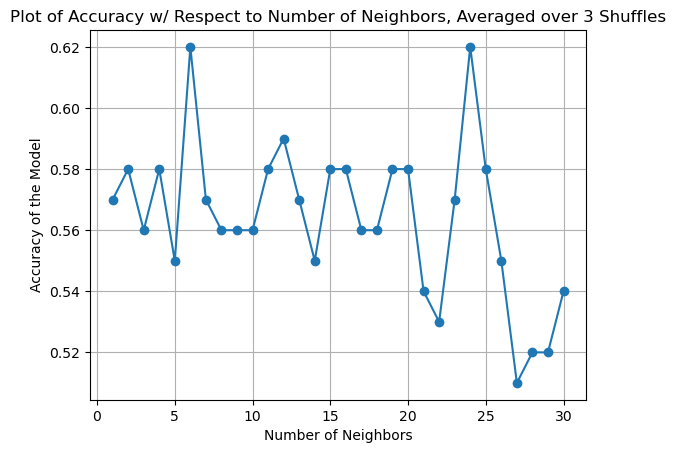

In [83]:
#reshu=[np.average([train3dknn(1,neighbors=i,shuffle=True) for j in range(3)]) for i in range(1,31)]
#reshu (result was rounded)


shuffled_acc_per_neigh= [0.57, 0.58, 0.56, 0.58, 0.55, 0.62, 0.57, 0.56, 0.56, 0.56,
                         0.58, 0.59, 0.57, 0.55, 0.58, 0.58, 0.56, 0.56, 0.58, 0.58,
                         0.54, 0.53, 0.57, 0.62, 0.58, 0.55, 0.51, 0.52, 0.52, 0.54]

# Plotting
plt.plot(np.arange(1,31), shuffled_acc_per_neigh, marker='o')
plt.title('Plot of Accuracy w/ Respect to Number of Neighbors, Averaged over 3 Shuffles')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy of the Model')
plt.grid(True)
plt.show()


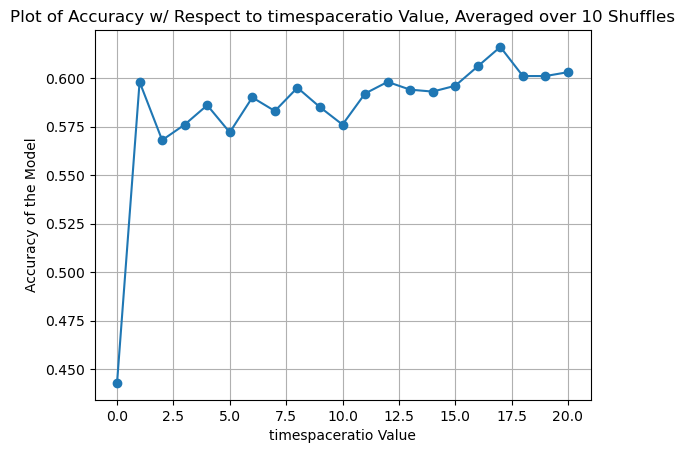

In [84]:
#[np.average([train3dknn(i,neighbors=6,shuffle=True) for j in range(10)]) for i in range(11)]=[0.445, 0.59 , 0.587, 0.621, 0.582, 0.6  , 0.565, 0.592, 0.575,0.588, 0.605]

shuffled_acc_per_timespace=[0.443, 0.598, 0.568, 0.576, 0.586, 0.572, 0.59 , 0.583, 0.595,
       0.585, 0.576, 0.592, 0.598, 0.594, 0.593, 0.596, 0.606, 0.616,
       0.601, 0.601, 0.603]
# Plotting
plt.plot(shuffled_acc_per_timespace, marker='o')
plt.title('Plot of Accuracy w/ Respect to timespaceratio Value, Averaged over 10 Shuffles')
plt.xlabel('timespaceratio Value')
plt.ylabel('Accuracy of the Model')
plt.grid(True)
plt.show()


### b) Visualizing data

#### With 3 genera

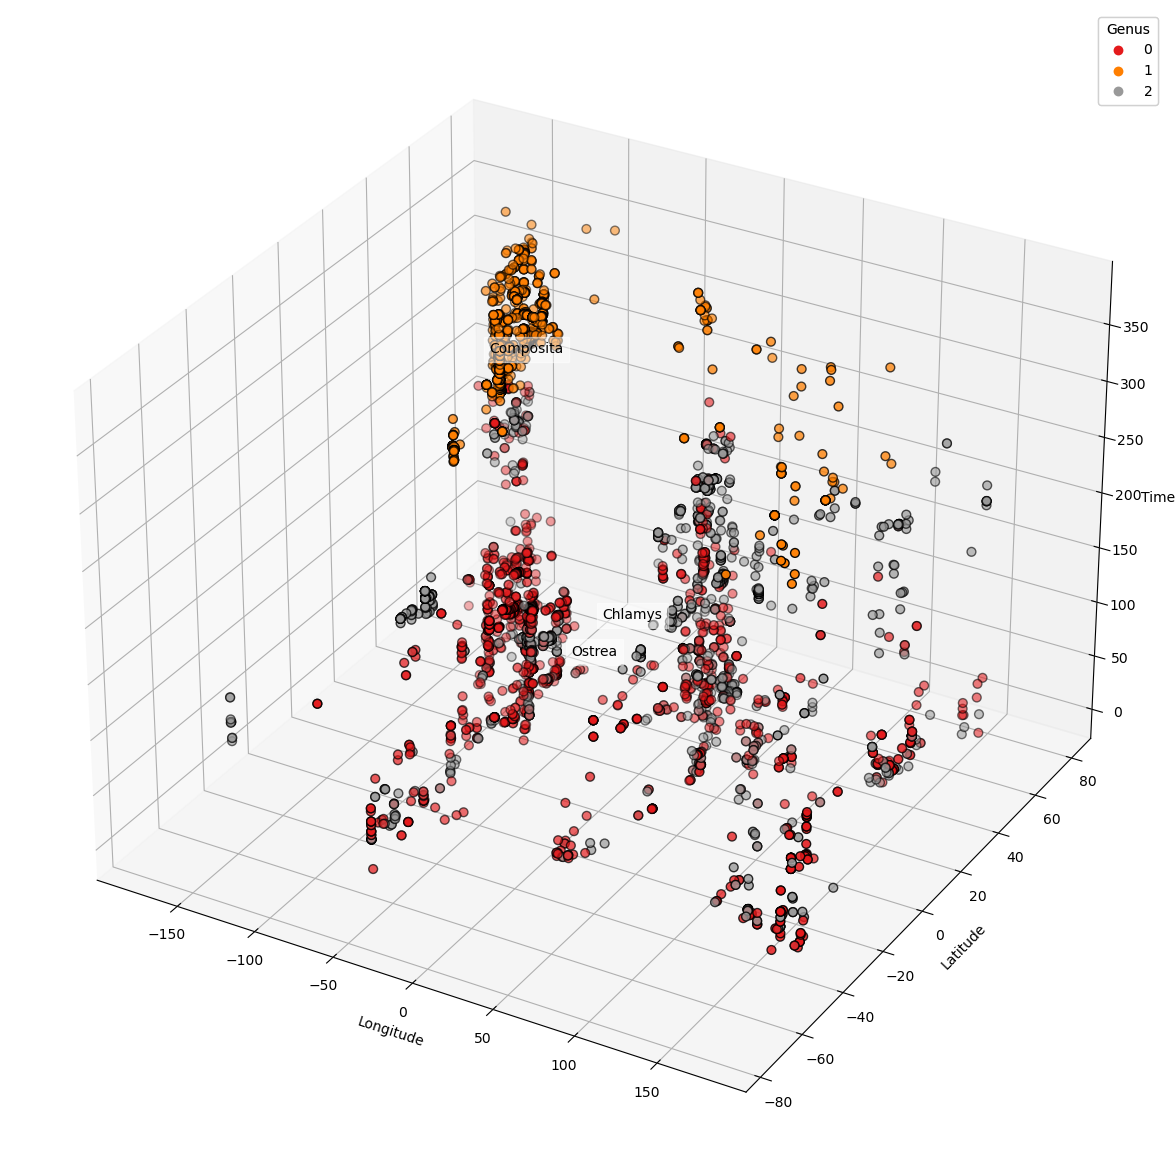

In [85]:
#3D Vizualisation added recently by me --> Oscar :) 

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data3d['lng'], data3d['lat'], data3d['time'], c=data3d['genus'].map({'Ostrea': 0, 'Composita': 1, 'Chlamys': 2}), cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Genus")
ax.add_artist(legend1)


for name, label in [('Ostrea', 0), ('Composita', 1), ('Chlamys', 2)]:
    ax.text3D(data3d[data3d['genus'] == name]['lng'].mean(),
              data3d[data3d['genus'] == name]['lat'].mean(),
              data3d[data3d['genus'] == name]['time'].mean(),
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

plt.show()


#### With 10 genera

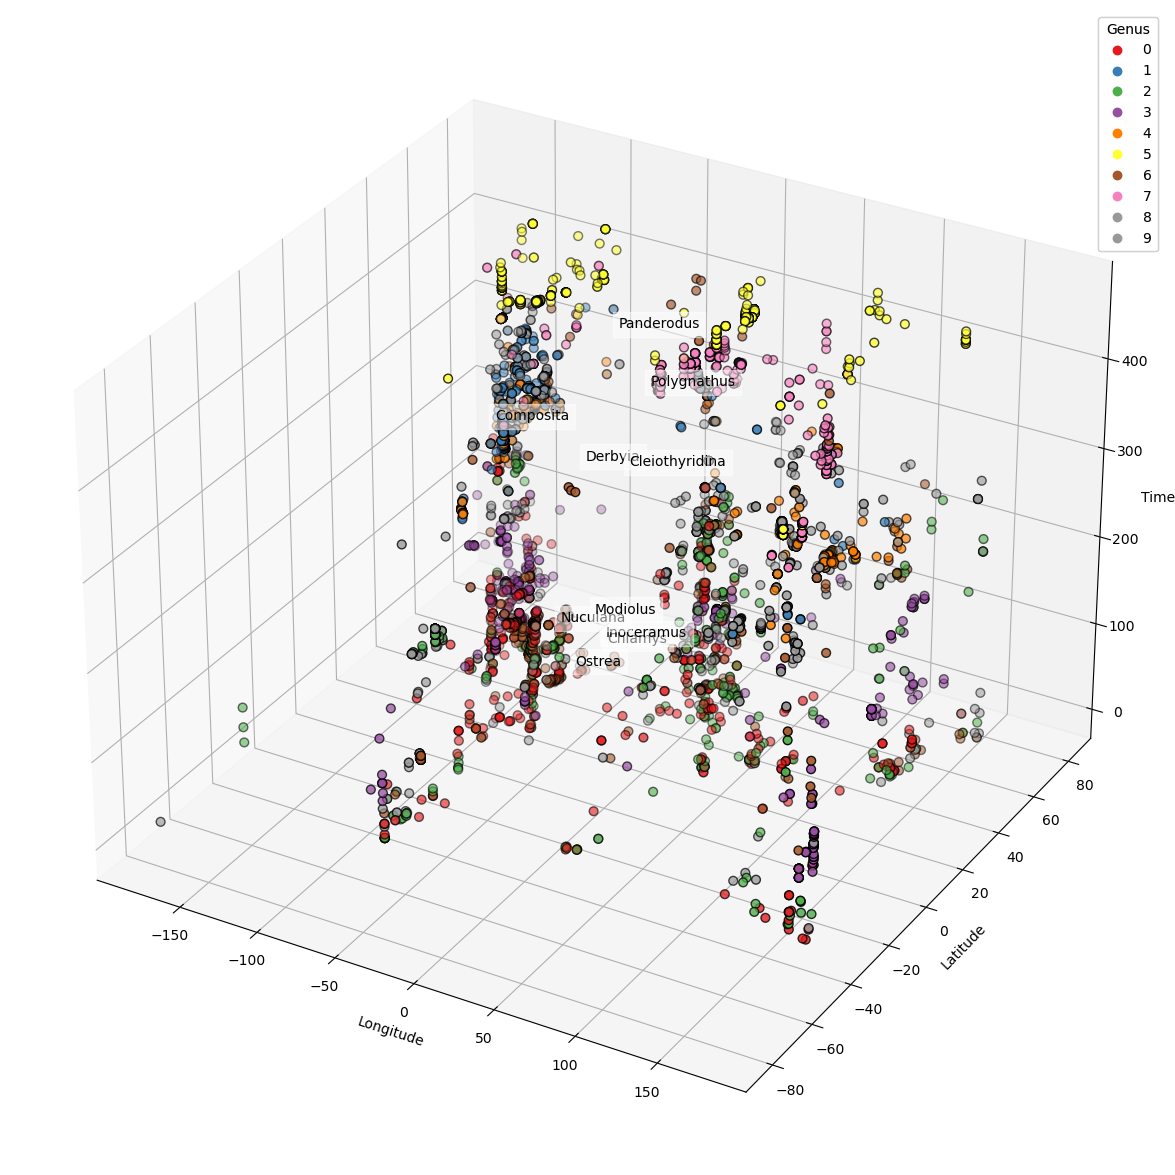

In [86]:
fig = plt.figure(figsize=(20, 15))  # Adjust the size as needed

ax = fig.add_subplot(111, projection='3d')

# Filter data to include only the first 100 occurrences of each genus
filtered_data = pd.concat([data3d[data3d['genus'] == name][:500] for name in ['Ostrea', 'Composita', 'Chlamys', 'Inoceramus', 'Derbyia', 'Panderodus', 'Nuculana', 'Polygnathus', 'Cleiothyridina', 'Modiolus']])

scatter = ax.scatter(filtered_data['lng'], filtered_data['lat'], filtered_data['time'], c=filtered_data['genus'].map({'Ostrea': 0, 'Composita': 1, 'Chlamys': 2, 'Inoceramus':3, 'Derbyia': 4, 'Panderodus': 5, 'Nuculana': 6, 'Polygnathus': 7, 'Cleiothyridina': 8, 'Modiolus': 9}), cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Genus")
ax.add_artist(legend1)

genus_names = ['Ostrea', 'Composita', 'Chlamys', 'Inoceramus', 'Derbyia', 'Panderodus', 'Nuculana', 'Polygnathus', 'Cleiothyridina', 'Modiolus']
for name in genus_names:
    ax.text3D(filtered_data[filtered_data['genus'] == name]['lng'].mean(),
              filtered_data[filtered_data['genus'] == name]['lat'].mean(),
              filtered_data[filtered_data['genus'] == name]['time'].mean(),
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

plt.show()

In [87]:
train3dknn(3)

0.49

### Paleolongitude + Time

In [88]:
# Creating the dataset the exact same way as before
paleodata3d=data.copy
paleodata3d=data[['paleolng', 'paleolat', 'genus']].copy()
paleodata3d['time']=(data['max_ma']+data['min_ma'])/2
paleodata3d = paleodata3d[paleodata3d['genus'].isin(['Ostrea', 'Composita', 'Chlamys','Inoceramus','Derbyia',"Panderodus","Nuculana","Polygnathus","Cleiothyridina","Modiolus"])]
paleodata3d = paleodata3d.sample(frac=1).reset_index(drop=True) # randomize the rows so that there is no bias in the order of the rows
paleodata3d

,paleolng,paleolat,genus,time
0,18.05,-34.69,Chlamys,3.094
1,-58.47,13.10,Ostrea,13.789
2,-63.02,35.90,Modiolus,39.650
3,-33.81,-19.57,Composita,322.250
4,51.25,-37.76,Cleiothyridina,257.035
...,...,...,...,...
13822,-68.21,34.57,Inoceramus,77.050
13823,-38.18,16.21,Composita,266.950
13824,-48.35,39.31,Ostrea,57.250
13825,15.75,33.38,Chlamys,160.400


In [89]:
train3dknn(3,neighbors= 8, features=['paleolat','paleolng','time'],data=paleodata3d)

0.63

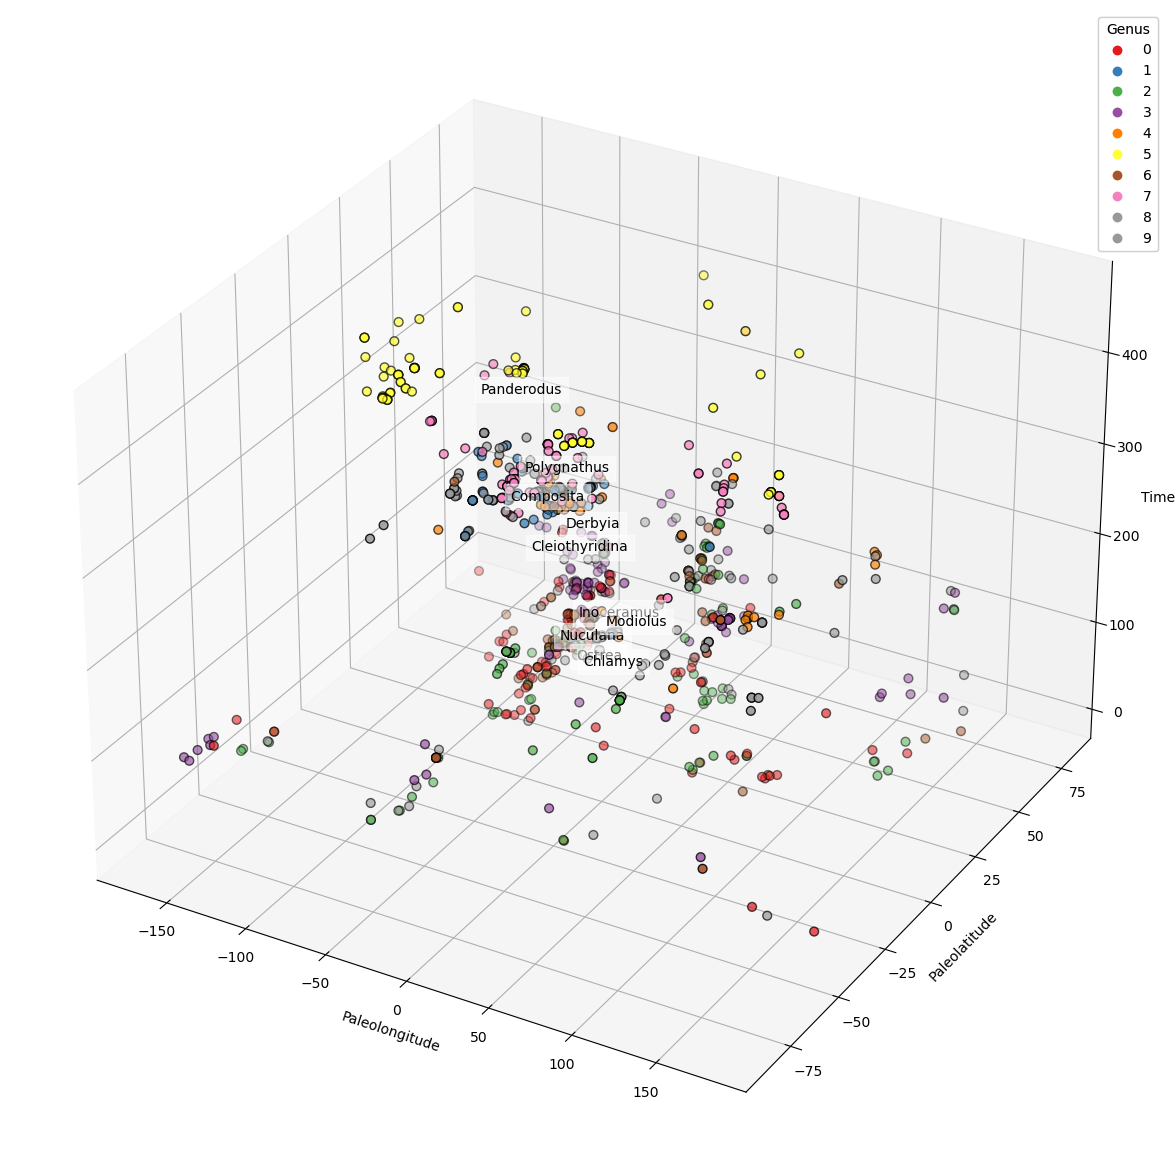

In [90]:
fig = plt.figure(figsize=(20, 15))  # Adjust the size as needed

ax = fig.add_subplot(111, projection='3d')

# Filter data to include only the first 100 occurrences of each genus
filtered_paleodata = pd.concat([paleodata3d[paleodata3d['genus'] == name][:100] for name in ['Ostrea', 'Composita', 'Chlamys', 'Inoceramus', 'Derbyia', 'Panderodus', 'Nuculana', 'Polygnathus', 'Cleiothyridina', 'Modiolus']])

scatter = ax.scatter(filtered_paleodata['paleolng'], filtered_paleodata['paleolat'], filtered_paleodata['time'], c=filtered_paleodata['genus'].map({'Ostrea': 0, 'Composita': 1, 'Chlamys': 2, 'Inoceramus':3, 'Derbyia': 4, 'Panderodus': 5, 'Nuculana': 6, 'Polygnathus': 7, 'Cleiothyridina': 8, 'Modiolus': 9}), cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel('Paleolongitude')
ax.set_ylabel('Paleolatitude')
ax.set_zlabel('Time')

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Genus")
ax.add_artist(legend1)

genus_names = ['Ostrea', 'Composita', 'Chlamys', 'Inoceramus', 'Derbyia', 'Panderodus', 'Nuculana', 'Polygnathus', 'Cleiothyridina', 'Modiolus']
for name in genus_names:
    ax.text3D(filtered_paleodata[filtered_paleodata['genus'] == name]['paleolng'].mean(),
              filtered_paleodata[filtered_paleodata['genus'] == name]['paleolat'].mean(),
              filtered_paleodata[filtered_paleodata['genus'] == name]['time'].mean(),
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

plt.show()

In [91]:
data3d

,lng,lat,genus,time
0,-86.300003,37.479168,Cleiothyridina,322.250
1,-1.550000,50.629166,Ostrea,35.550
2,-70.166664,10.833333,Ostrea,13.789
3,173.501602,-42.548801,Inoceramus,84.650
4,-99.305832,31.490278,Composita,301.150
...,...,...,...,...
13822,44.833332,26.333332,Modiolus,164.800
13823,-70.283333,-28.950001,Modiolus,193.050
13824,-94.731667,37.668888,Composita,309.850
13825,-76.791946,37.517502,Nuculana,44.550


---
# 3) Logistic regression <a id='logistic_regression'></a>

#### [Jump back to glossary](#glossary)

---
# 4) Decision tree <a id='decision_tree'></a>

This section of the project is dedicated to creating a decision tree to attempt to classify each fossil based on criterions.

#### [Jump back to glossary](#glossary)

### a) Data processing

#### i) Separating the data in training and testing set

Let's look at the data again.

In [92]:
data

,max_ma,min_ma,genus,lng,lat,paleolng,paleolat,lithology1,composition
0,353.8,345.3,Australosutura,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
1,353.8,345.3,Carbonocoryphe,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
2,353.8,345.3,Thigriffides,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
3,353.8,345.3,Pudoproetus,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
4,353.8,345.3,Pudoproetus,-98.099998,31.000000,-65.59,-27.46,"""carbonate""","low Mg calcite, chitin"
...,...,...,...,...,...,...,...,...,...
743654,99.6,93.5,Lepicerus,96.720001,26.360001,105.50,8.29,amber,chitin
743655,468.1,460.9,Eremotoechia,-86.784721,33.311111,-114.63,-8.13,"""limestone""",low Mg calcite
743656,467.3,458.4,Eremotoechia,-84.129166,35.741669,-112.38,-10.30,"""limestone""",low Mg calcite
743657,467.3,458.4,Eremotoechia,-84.125000,35.750000,-112.37,-10.29,"""limestone""",low Mg calcite


**Note on classes.**  
To make a simple decision tree, we'll start with removing the lithology and composition attributes before changing it with one-hot encoding. 

In [93]:
print("-----\nGENUS\n")
genu = list(set(data.loc[:,"genus"]))
#print("values: ", genu)
print("number of unique values: ", len(genu))

print("-----\nLITHOLOGY1:\n")
lith = list(set(data.loc[:,"lithology1"])) 
#print("values:", lith,'\n')
print("Number of unique values: ", len(lith))

print("------\nCOMPOSITION\n")
comp = list(set(data.loc[:,"composition"]))
#print("Values:", comp,'\n')
print("Number of unique values: ", len(comp))
print("-----")

# Print the ranking
#print("Ranking of genera with the most occurrences:")
#for index, row in genus_counts.iterrows():
#    print(f"{index+1}. {row['genus']}: {row['count']} occurrences")

-----
GENUS

number of unique values:  52139
-----
LITHOLOGY1:

Number of unique values:  47
------
COMPOSITION

Number of unique values:  23
-----


**Unique Genuses.**  
There are far too many unique genus values. We'll focus on the 30 most featured species, selecting more or less depending on what is needed.
([See ranking](#ranking))
1. Ostrea: 1828 occurrences
2. Composita: 1722 occurrences
3. Chlamys: 1531 occurrences
4. Inoceramus: 1368 occurrences
5. Derbyia: 1330 occurrences
6. Panderodus: 1316 occurrences
7. Nuculana: 1256 occurrences
8. Polygnathus: 1184 occurrences
9. Cleiothyridina: 1172 occurrences
10. Modiolus: 1120 occurrences
11. Favosites: 1092 occurrences
12. Atrypa: 1092 occurrences
13. Ozarkodina: 1081 occurrences
14. Dentalium: 1080 occurrences
15. Anomia: 1076 occurrences
...

**Result of training the model with *all* genuses**  
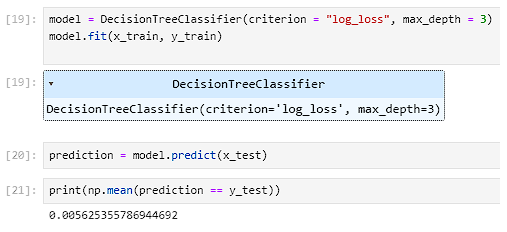  
The returned accuracy is extremely poor, due the limited depth of the decision tree and massive pool of genuses. This confirms our decision to choose a limited amount of genues.


In [94]:
species_to_keep = ['Ostrea','Composita','Chlamys','Inoceramus','Derbyia','Panderodus','Nuculana','Polygnathus','Cleiothyridina'
                  'Modiolus','Favosites','Atrypa','Ozarkodina','Dentalium','Anomia', 'Hustedia','Glycymeris','Bairdia','Lingula','Isotelus'
                  'Linoproductus','Astarte','Plagiostoma','Porites','Neospirifer','Camptonectes','Palaeoneilo','Corbula','Euspira','Nucula']

## INCLUDE ALL GENUSES
genus_counts = data['genus'].value_counts().reset_index()
genus_counts.columns = ['genus', 'count']
genus_counts = genus_counts.sort_values(by='count', ascending=False)
#print(type(genus_counts))
species_to_keep = (genus_counts["genus"].to_list())

In [95]:
def decision_tree_separate_train_test(df, feature_to_predict,ratio=0.7, shuffle = False):
    '''
    Splits a dataframe 'df' into four np arrays for training and testing (+validation)
    Parameters:
    - df : dataframe containing all the data
    - ratio : size of the training set wrt total data. 0.7 by default but can be changed.
    - Shuffle: Adds shuffle to the data set, false by default.
    '''
    df_copy = df
    if shuffle:
        df_copy = df_copy.sample(frac=1).reset_index(drop=True)
    num_samples = df_copy.shape[0]
    #print(num_samples)
    other_features = df.columns.values.tolist()
    other_features.remove(feature_to_predict)
    training_x = df_copy.loc[:num_samples*(ratio),other_features]
    training_y = df_copy.loc[:num_samples*(ratio),[feature_to_predict]]
    testing_x = df_copy.loc[num_samples*(ratio):, other_features]
    testing_y = df_copy.loc[num_samples*(ratio):, [feature_to_predict]]

    training_y = training_y.loc[:,[feature_to_predict]].values.flatten()
    testing_y = testing_y.loc[:, [feature_to_predict]].values.flatten()
    
    return training_x, testing_x, training_y, testing_y


In [96]:
x_train, x_test, y_train, y_test = decision_tree_separate_train_test(data, "genus",0.7, True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(520562, 8) (520562,)
(223097, 8) (223097,)


### b) Decision tree without categorical

**Removal of categorical values.**  
We'll start with removing categorical values as this allows for a simple model to start with as a baseline.

In [97]:
def train_decision_tree_class_without_cat_labels(df, genus_to_keep = 10, training_ratio_split=0.7, maxdepth=10, show_graph=False, shuffl = True):
    '''
    Function that treats data, trains and predicts the dinosaur data. Returns the accuracy of the model's predictions.
    Parameters:
    df: DataFrame to feed to the model to train on
    genus_to_keep: integer to indicate the X first prevalent species to keep in the data.
    training_ratio_split: float between 0 and 1 to split the proportions of training data and validation data.
    maxdepth: integer to indicate the max depth/height of the decision tree
    show_graph: boolean to indicate whether we would like to see the graph representation of the decision tree.
    shuffl: Shuffle data values.
    '''
    
    if genus_to_keep >= len(species_to_keep):
        genus_to_keep = len(species_to_keep)-1

    #Keep the top X most prevalent species among all entries, and save the parameters
    keep = species_to_keep[:genus_to_keep]
    data_decision_without_class = df[data['genus'].isin(keep)]
    data_decision_without_class = data_decision_without_class[["max_ma","min_ma","genus","lng","lat","paleolng","paleolat"]]
    
    x_train, x_test, y_train, y_test = decision_tree_separate_train_test(data_decision_without_class, "genus",training_ratio_split, shuffl)
    
    model = DecisionTreeClassifier(criterion = "entropy", max_depth=maxdepth)
    model.fit(x_test, y_test)
    prediction = model.predict(x_train)

    dot_data = export_graphviz(
        model, out_file=None, feature_names=list(x_train), filled=True, 
        rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data) 
    if show_graph:
        display(graph)
        graph.render(None, format='png', cleanup=True)
    
    return (np.mean(prediction == y_train))

In [98]:
print(train_decision_tree_class_without_cat_labels(data, 10, 0.7, 10))

NameError: name 'graphviz' is not defined

*Peculiarity.*  
Setting the training ratio split parameter to unreasonably small values (training batch takes 0.3 while testing takes 0.7, for instance) leads to still regular accuracy.

### c) Decision tree with categorical labels

**Categorical Labels**    
In order to pass our dataframe with categorical values through the classifier model, we need to transform them into numerical values in order for them to be treated. We can transform the categorical columns into direct numerical columns through a direct mapping, or increase the dimensionality through one hot encoding. 

In [102]:
#ONE HOT ENCODING
keep = species_to_keep[:10]
df_encoded = data[data['genus'].isin(keep)]
df_encoded = pd.get_dummies(df_encoded, columns=['lithology1', 'composition' ])
df_encoded

,max_ma,min_ma,genus,lng,lat,paleolng,paleolat,"lithology1_""carbonate""","lithology1_""limestone""","lithology1_""mixed carbonate-siliciclastic""",...,lithology1_siderite,lithology1_siltstone,lithology1_slate,lithology1_tuff,lithology1_wackestone,composition_aragonite,"composition_aragonite, low Mg calcite",composition_hydroxyapatite,composition_low Mg calcite,"composition_low Mg calcite, aragonite"
112,313.8,305.9,Derbyia,-94.708054,37.839722,-30.17,-6.36,0,0,0,...,0,0,0,0,0,0,0,0,1,0
133,313.8,305.9,Nuculana,-95.638885,36.415001,-31.58,-7.15,0,0,0,...,0,0,0,0,0,1,0,0,0,0
137,313.8,305.9,Derbyia,-90.025833,40.610832,-25.60,-5.86,0,0,0,...,0,0,0,0,0,0,0,0,1,0
188,313.8,305.9,Nuculana,-96.378059,35.022221,-32.86,-7.97,0,0,0,...,0,0,0,0,0,1,0,0,0,0
217,313.8,305.9,Composita,-95.854721,36.123611,-31.89,-7.29,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742473,100.5,93.9,Ostrea,-121.211998,37.203999,-79.11,43.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0
742486,89.8,83.6,Nuculana,-121.176003,37.221001,-80.74,45.15,0,0,0,...,0,0,0,0,0,1,0,0,0,0
742653,72.1,66.0,Ostrea,-121.094002,37.192001,-85.06,50.00,0,1,0,...,0,0,0,0,0,0,0,0,1,0
742668,72.1,66.0,Ostrea,-121.094002,37.192001,-85.06,50.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [103]:
#Use a one hot encoder
def train_decision_tree_class_with_cat_labels(df, genus_to_keep = 10, training_ratio_split=0.7, maxdepth=10, show_graph=False):
    '''
    Function that treats data, trains and predicts the dinosaur data based on 
    Parameters:
    df: DataFrame to feed to the model to train on
    genus_to_keep: integer to indicate the X first prevalent species to keep in the data.
    training_ratio_split: float between 0 and 1 to split the proportions of training data and validation data.
    maxdepth: integer to indicate the max depth/height of the decision tree
    show_graph: boolean to indicate whether we would like to see the graph representation of the decision tree.
    '''
    if genus_to_keep >= len(species_to_keep):
        genus_to_keep = len(species_to_keep) -1
    #keep the X most prevalent species in the dataset.
    keep = species_to_keep[:genus_to_keep]

    #Perform one hot encoding on the known categorical columns.
    df_encoded = data[data['genus'].isin(keep)]
    df_encoded = pd.get_dummies(df_encoded, columns=['lithology1', 'composition' ])
    
    #Produce the training and validation sets
    x_train, x_test, y_train, y_test = decision_tree_separate_train_test(df_encoded, "genus",training_ratio_split, True)

    #Create, train, and predict a model to the dataset
    model = DecisionTreeClassifier(criterion = "entropy", max_depth=maxdepth)
    model.fit(x_test, y_test)
    prediction = model.predict(x_train)

    #Create the decision tree representation
    dot_data = export_graphviz(
        model, out_file=None, feature_names=list(x_train), filled=True, 
        rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data) 
    if show_graph:
        display(graph)
        graph.render(None, format='png', cleanup=True)
    
    return (np.mean(prediction == y_train))

In [104]:
print(train_decision_tree_class_with_cat_labels(data, 10, 0.7, 10))

NameError: name 'graphviz' is not defined

*Remark.*  
Much better results are achieved here than on the parts without the categories here. 

### d) Visualization and results

In [105]:
xaxis = []
yaxis = []
for i in range(1, 50):
    yaxis.append(train_decision_tree_class_without_cat_labels(data, 10, 2*i/100))
    xaxis.append(2*i/100)
plt.plot(xaxis, yaxis)
plt.title("aaa")

NameError: name 'graphviz' is not defined

In [106]:
without = []
withlabel = []
xaxis = []
yaxis = []

for i in range(1,50):
    yaxis.append(train_decision_tree_class_with_cat_labels(data, i, 0.5, 10, False))
    xaxis.append(i)

plt.plot(xaxis, yaxis)
#for i in range(10):
    #without.append(train_decision_tree_class_without_cat_labels(data, 30, 0.5, 7, False))
    #b = train_decision_tree_class_with_cat_labels(data, 30, 0.5, 5, False)
    #print(b)
    #withlabel.append(b)
#print(np.average(without))
#print(np.average(withlabel))

NameError: name 'graphviz' is not defined

In [107]:
xaxis = []
yaxis = []
for i in range(1, 50):
    yaxis.append(train_decision_tree_class_with_cat_labels(data, 10, 2*i/100))
    xaxis.append(2*i/100)
plt.plot(xaxis, yaxis)

NameError: name 'graphviz' is not defined

---
# 5) PCA for higher dimensions <a id='pca'></a> 

#### [Jump back to glossary](#glossary)

In [108]:

#necessary imports 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import datasets

from sklearn.decomposition import PCA


## a)  Coordinates + Paleolatitude + Time (2 principal components)

In [109]:
datapca = data[['paleolng', 'paleolat', 'genus', 'lat', 'lng']].copy()
datapca['time']=(data['max_ma']+data['min_ma'])/2
datapca = datapca[datapca['genus'].isin(['Ostrea', 'Composita', 'Chlamys','Inoceramus','Derbyia',"Panderodus","Nuculana","Polygnathus","Cleiothyridina","Modiolus"])]
datapca = datapca.sample(frac=1).reset_index(drop=True)
datapca

,paleolng,paleolat,genus,lat,lng,time
0,-45.14,-27.65,Cleiothyridina,34.587502,-87.629166,331.20000
1,23.44,28.12,Ostrea,40.633888,-0.103889,123.95500
2,-33.47,-19.19,Composita,38.404167,-86.591667,322.25000
3,22.65,40.98,Cleiothyridina,74.376999,-21.576000,257.03500
4,-144.83,-85.37,Nuculana,-33.000000,-55.000000,400.45000
...,...,...,...,...,...,...
13822,-11.97,-34.96,Cleiothyridina,51.633331,-3.966667,343.90000
13823,-63.68,43.10,Inoceramus,36.353333,-104.596947,91.85000
13824,18.94,37.90,Chlamys,48.000000,6.000000,193.05000
13825,7.27,43.70,Modiolus,43.701389,7.268056,0.00585


/var/folders/91/v98ksgyn3zb26xq2gsrl4jzr0000gn/T/ipykernel_39554/2051519339.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(genus_list))


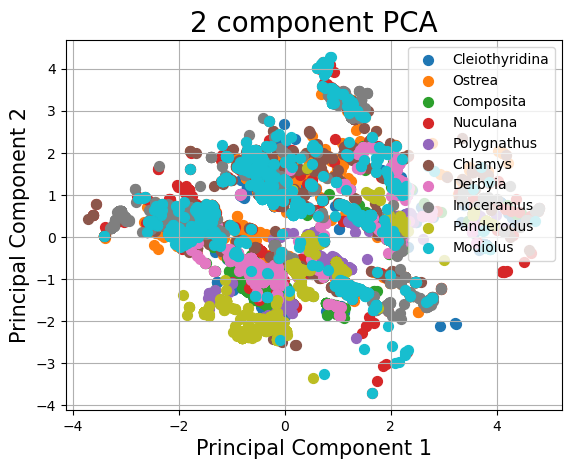

In [110]:
# Features to include in PCA
features = ['paleolng', 'paleolat', 'lat', 'lng', 'time']
# Separating out the features
x = datapca.loc[:, features].values
# Separating out the target
y = datapca.loc[:, ['genus']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])



final_df = pd.concat([principal_df, datapca[['genus']]], axis=1)



fig, ax = plt.subplots()
genus_list = final_df['genus'].unique()
colors = plt.cm.get_cmap('tab10', len(genus_list))

# Plot each genus
for i, genus in enumerate(genus_list):
    indices_to_keep = final_df['genus'] == genus
    ax.scatter(final_df.loc[indices_to_keep, 'principal component 1']
               , final_df.loc[indices_to_keep, 'principal component 2']
               , c=[colors(i)]
               , s=50)

ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 component PCA', fontsize=20)
ax.legend(genus_list)
ax.grid()

plt.show()

In [111]:
final_df 

,principal component 1,principal component 2,genus
0,0.059056,-1.459280,Cleiothyridina
1,-0.198940,1.169414,Ostrea
2,-0.058160,-1.170837,Composita
3,-0.848573,1.007050,Cleiothyridina
4,1.653405,-3.709068,Nuculana
...,...,...,...
13822,0.691382,-0.856095,Cleiothyridina
13823,-1.693417,0.328079,Inoceramus
13824,-0.338135,1.114457,Chlamys
13825,-0.761734,1.800476,Modiolus


### Now we can apply kNN on this new_dataset with PCA 

In [112]:
accuracypca = knn_classification(final_df, ['principal component 1', 'principal component 2'], 'genus', test_size=0.2, n_neighbors=9)
accuracypca

0.6258134490238612

Better accuracy by 3% then normal kNN. But still not an enormous jump foward

## b)  Coordinates + Paleolatitude + Time (3 principal components)

/var/folders/91/v98ksgyn3zb26xq2gsrl4jzr0000gn/T/ipykernel_39554/773207570.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(genus_list))


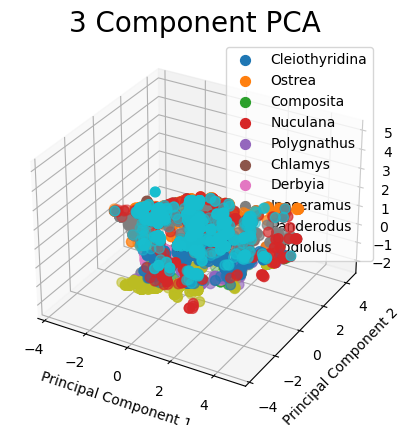

In [113]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2', 'principal component 3'])

final_df3D = pd.concat([principal_df, datapca[['genus']]], axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
genus_list = final_df3D['genus'].unique()
colors = plt.cm.get_cmap('tab10', len(genus_list))

# Plot each genus in 3D
for i, genus in enumerate(genus_list):
    indices_to_keep = final_df3D['genus'] == genus
    ax.scatter(final_df3D.loc[indices_to_keep, 'principal component 1'],
               final_df3D.loc[indices_to_keep, 'principal component 2'],
               final_df3D.loc[indices_to_keep, 'principal component 3'],
               c=[colors(i)],
               s=50)

ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_zlabel('Principal Component 3', fontsize=10)
ax.set_title('3 Component PCA', fontsize=20)
ax.legend(genus_list)

plt.show()


In [114]:
train3dknn(3,neighbors= 10, features=['principal component 1','principal component 2','principal component 3'],data=final_df3D)

0.62

In 3D PCA does not work and gives very unsatisfactory results. less than normal kNN 

## c) Coordinates + Paleocoordinates + Time + Composition 

In [115]:
#ONE HOT ENCODING
keep = species_to_keep[:10]
df_encoded = data[data['genus'].isin(keep)]
df_encoded = pd.get_dummies(df_encoded, columns=['lithology1', 'composition' ])
df_encoded

,max_ma,min_ma,genus,lng,lat,paleolng,paleolat,"lithology1_""carbonate""","lithology1_""limestone""","lithology1_""mixed carbonate-siliciclastic""",...,lithology1_siderite,lithology1_siltstone,lithology1_slate,lithology1_tuff,lithology1_wackestone,composition_aragonite,"composition_aragonite, low Mg calcite",composition_hydroxyapatite,composition_low Mg calcite,"composition_low Mg calcite, aragonite"
112,313.8,305.9,Derbyia,-94.708054,37.839722,-30.17,-6.36,0,0,0,...,0,0,0,0,0,0,0,0,1,0
133,313.8,305.9,Nuculana,-95.638885,36.415001,-31.58,-7.15,0,0,0,...,0,0,0,0,0,1,0,0,0,0
137,313.8,305.9,Derbyia,-90.025833,40.610832,-25.60,-5.86,0,0,0,...,0,0,0,0,0,0,0,0,1,0
188,313.8,305.9,Nuculana,-96.378059,35.022221,-32.86,-7.97,0,0,0,...,0,0,0,0,0,1,0,0,0,0
217,313.8,305.9,Composita,-95.854721,36.123611,-31.89,-7.29,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742473,100.5,93.9,Ostrea,-121.211998,37.203999,-79.11,43.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0
742486,89.8,83.6,Nuculana,-121.176003,37.221001,-80.74,45.15,0,0,0,...,0,0,0,0,0,1,0,0,0,0
742653,72.1,66.0,Ostrea,-121.094002,37.192001,-85.06,50.00,0,1,0,...,0,0,0,0,0,0,0,0,1,0
742668,72.1,66.0,Ostrea,-121.094002,37.192001,-85.06,50.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [116]:
selected_row = df_encoded


/var/folders/91/v98ksgyn3zb26xq2gsrl4jzr0000gn/T/ipykernel_39554/2930692816.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(genus_list))


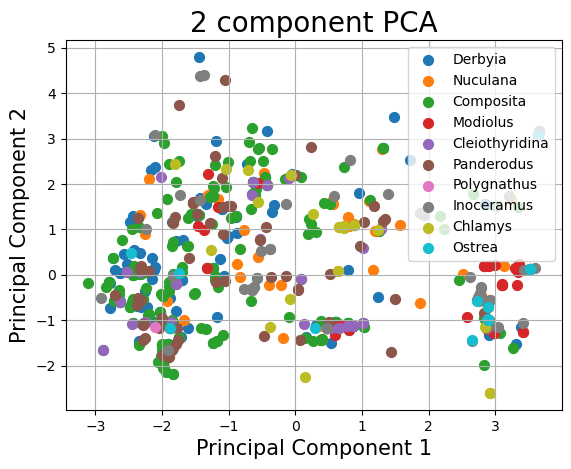

In [117]:
# Features to include in PCA
features = ['paleolng', 'paleolat', 'lat', 'lng', 'max_ma', 'min_ma', 'lithology1_"carbonate"', 'lithology1_"limestone"', 'lithology1_"mixed carbonate-siliciclastic"', 'lithology1_siderite', 'lithology1_siltstone', 'lithology1_slate', 'lithology1_tuff', 'lithology1_wackestone','composition_aragonite', 'composition_aragonite, low Mg calcite', 'composition_hydroxyapatite','composition_low Mg calcite', 'composition_low Mg calcite, aragonite']
# Separating out the features
x = selected_row.loc[:, features].values
# Separating out the target
y = selected_row.loc[:, ['genus']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])

final_df = pd.concat([principal_df, df_encoded[['genus']]], axis=1)
#final_df = pd.concat([principal_df, df_encoded[['max_ma', 'min_ma']]])
final_df = final_df.dropna(axis=0)




fig, ax = plt.subplots()
genus_list = final_df['genus'].unique()
colors = plt.cm.get_cmap('tab10', len(genus_list))

# Plot each genus
for i, genus in enumerate(genus_list):
    indices_to_keep = final_df['genus'] == genus
    ax.scatter(final_df.loc[indices_to_keep, 'principal component 1']
               , final_df.loc[indices_to_keep, 'principal component 2']
               , c=[colors(i)]
               , s=50)

ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 component PCA', fontsize=20)
ax.legend(genus_list)
ax.grid()

plt.show()


In [118]:
accuracypca = knn_classification(final_df, ['principal component 1', 'principal component 2'], 'genus', test_size=0.2, n_neighbors= 12)

print(accuracypca)

0.4076923076923077


#### Create a new KNN classifier which is adapter for our data_set

In [123]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
data = df_encoded

# Encode the 'genus' column
label_encoder = LabelEncoder()
data['genus'] = label_encoder.fit_transform(data['genus'])

# Separate features and target
X = data.drop(columns=['genus'])
y = data['genus']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

ModuleNotFoundError: No module named 'tensorflow'